In [0]:
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import plotly.graph_objects as go
import unicodedata
import re
import numpy as np
import io
import time
import jieba

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preprocessing

In [0]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# cut chinese
def cutword(sentence):
    output = []
    for word in jieba.cut(sentence, cut_all=False):
        output.append(word)
    output = ' '.join(output)
    return output

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    w = re.sub(r"([?.!,？。！，])", r" \1 ", w)
    # delete extra spaces
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    # as well as Chinese characters
    w = re.sub(r"[^a-zA-Z?.!,？。！，\u4e00-\u9FFF]+", " ", w)

    # cut words
    if len(re.findall('([a-z])',w)) == 0:
        try:
            w = cutword(w)
        except:
            pass

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

# Return word pairs in the format: [ENGLISH, CHINESE]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = []
    for line in lines[:num_examples]:
        sentences = line.split('\t')[:2]
        word_pairs.append((preprocess_sentence(sentences[0]),
                           preprocess_sentence(sentences[1])))
    return word_pairs

In [0]:
cutword("我可以借这本书吗？" )

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.599 seconds.
Prefix dict has been built successfully.


'我 可以 借 这 本书 吗 ？'

In [0]:
en_sentence = u"May I borrow this book?"
zh_sentence = u"我可以借这本书吗？"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(zh_sentence))

<start> may i borrow this book ?  <end>
<start> 我 可以 借 这 本书 吗   ？   <end>


In [0]:
path_to_file = '/content/drive/My Drive/cmn.txt'

for l,k in create_dataset(path_to_file, 10):
    print(l)
    print(k)
    print('English length: {}; Chinese length: {}'.format(len(l),len(k)))
    print('--' *30)

<start> hi .  <end>
<start> 嗨   。   <end>
English length: 19; Chinese length: 21
------------------------------------------------------------
<start> hi .  <end>
<start> 你好   。   <end>
English length: 19; Chinese length: 22
------------------------------------------------------------
<start> run .  <end>
<start> 你 用 跑 的   。   <end>
English length: 20; Chinese length: 27
------------------------------------------------------------
<start> wait !  <end>
<start> 等等   ！   <end>
English length: 21; Chinese length: 22
------------------------------------------------------------
<start> wait !  <end>
<start> 等 一下   ！   <end>
English length: 21; Chinese length: 24
------------------------------------------------------------
<start> hello !  <end>
<start> 你好   。   <end>
English length: 22; Chinese length: 22
------------------------------------------------------------
<start> i try .  <end>
<start> 让 我 来   。   <end>
English length: 22; Chinese length: 25
----------------------------------------

In [0]:
english = []
chinese = []

for en, zh in create_dataset(path_to_file, None):
    english.append(en)
    chinese.append(zh)

print('--------- Original ---------')
with open (path_to_file) as f:
    for i in (f.read().split('\n')[-2].split('\t')):
        print(i)
print('')
print('--------- Processed ---------')
print(english[-1])
print(chinese[-1])
print('')
print('Number of English Sentences: ', len(english))
print('Number of Chinese sentences: ', len(chinese))

--------- Original ---------
If a person has not had a chance to acquire his target language by the time he's an adult, he's unlikely to be able to reach native speaker level in that language.
如果一個人在成人前沒有機會習得目標語言，他對該語言的認識達到母語者程度的機會是相當小的。
CC-BY 2.0 (France) Attribution: tatoeba.org #1230633 (alec) & #1205914 (cienias)

--------- Processed ---------
<start> if a person has not had a chance to acquire his target language by the time he s an adult , he s unlikely to be able to reach native speaker level in that language .  <end>
<start> 如果 一個 人 在 成人 前 沒 有 機會習 得 目標 語言   ，   他 對 該 語言 的 認識 達 到 母語者 程度 的 機會 是 相當 小 的   。   <end>

Number of English Sentences:  22075
Number of Chinese sentences:  22075


## Tokenization

In [0]:
# create a helper function to get the padded tensor length
# the default level(0.98) means that 98% of all sentences have fewer than n tokens
def get_pad_len(tensor, level=0.98): 
    n = 0
    while True:
        count = 0
        for i in tensor:
            if len(i) < n:
                count += 1
        if count / len(tensor) >= level:
            break
        n += 1
    return n

In [0]:
def to_tensor(lang, return_tensor=True, return_tokenizer=False):
    # Assigns the index (sequence) of each word in a text to X
    tokenizer = Tokenizer(filters=' ', oov_token='<OOV>') 
    tokenizer.fit_on_texts(lang)
    lang_tensor = tokenizer.texts_to_sequences(lang)
    lang_tensor = pad_sequences(lang_tensor,
                                maxlen=get_pad_len(lang_tensor), # use the previously created function
                                padding='post',
                                truncating='post') 
    if return_tensor:
        print('\nShape of data tensor:', lang_tensor.shape)
        return lang_tensor
    if return_tokenizer:
        return tokenizer

In [0]:
english_tokenizer = to_tensor(english, False, True)
english_tensor = to_tensor(english)
print('\nOriginal sentence:')
print(english[500])
print('\nTensor of the sentence:')
print(english_tensor[500])


Shape of data tensor: (22075, 17)

Original sentence:
<start> i m all ears .  <end>

Tensor of the sentence:
[   2    5   40   57 1360    4    3    0    0    0    0    0    0    0
    0    0    0]


In [0]:
chinese_tokenizer = to_tensor(chinese, False, True)
chinese_tensor = to_tensor(chinese)
print('\nOriginal sentence:')
print(chinese[500])
print('\nTensor of the sentence:')
print(chinese_tensor[500])


Shape of data tensor: (22075, 15)

Original sentence:
<start> 我 洗耳 恭聽   。   <end>

Tensor of the sentence:
[   2    5 6207 6208    4    3    0    0    0    0    0    0    0    0
    0]


In [0]:
english_vocab_size = len(english_tokenizer.word_index) + 1
chinese_vocab_size = len(chinese_tokenizer.word_index) + 1

print('Found {} unique tokens in English.\n'.format(english_vocab_size))
print('Found {} unique tokens in Chinese.\n'.format(chinese_vocab_size))

name_dict = ['Chinese', 'English']
for idx, lang in enumerate([chinese_tokenizer, english_tokenizer]):
    print('The 10 most frequent tokens in {} are:'.format(name_dict[idx]))
    for idx, word in enumerate(lang.word_index):
        if word not in ['<OOV>' , '<start>', '<end>']:
            print(word, end='|')
        if idx == 13:
            break
    print('\n')

Found 6237 unique tokens in English.

Found 14052 unique tokens in Chinese.

The 10 most frequent tokens in Chinese are:
。|我|的|了|你|他|？|在|是|她|，|

The 10 most frequent tokens in English are:
.|i|the|to|you|a|?|is|he|t|tom|



## Create Dataset

In [0]:
english_train, english_test, chinese_train, chinese_test = train_test_split(
    english_tensor, chinese_tensor, test_size=0.1)

In [0]:
BUFFER_SIZE = len(english_train)
BATCH_SIZE = 64
STEPS_PER_EPOCH = len(english_train)//BATCH_SIZE
EMBEDDING_DIM = 128
ENC_HIDDEN_DIM = 1024
DEC_HIDDEN_DIM = 1024

# creating a TensorFlow Dataset object 
dataset = tf.data.Dataset.from_tensor_slices((english_train, chinese_train)).shuffle(BUFFER_SIZE)

# batching
dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)

In [0]:
print(chinese_vocab_size)
print(english_vocab_size)

14052
6237


## Encoder-decoder with attention

In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, input_dim, embedding_dim, enc_hidden_dim, batch_size, dropout_rate=0.1):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.enc_hidden_dim = enc_hidden_dim
        # embed the word vectors
        self.embedding = tf.keras.layers.Embedding(input_dim, embedding_dim)
        # dropout layer for normalization
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        # GRU 
        self.gru = tf.keras.layers.GRU(self.enc_hidden_dim,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, init_state, training=True):
        """
        training -> bool
        """
        x = self.embedding(x)
        x = self.dropout(x)
        output, hidden = self.gru(x, initial_state = init_state, training=training)
        return output, hidden

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.enc_hidden_dim))

In [0]:
class Attention(tf.keras.layers.Layer):
    """ bahdanau-style assistive attention """

    def __init__(self, units):
        super(Attention, self).__init__()
        self.d1 = tf.keras.layers.Dense(units)
        self.d2 = tf.keras.layers.Dense(units)
        self.d3 = tf.keras.layers.Dense(1)

    def call(self, query, values):
        """
        encoder last hidden state is the query
        encoder outputs are the values
        """
        # dim from (64,1024) -> (64,1,1024)
        query_3d = tf.expand_dims(query, 1)

        scores = self.d3(tf.nn.tanh(
            self.d1(query_3d) + self.d2(values)))
        # values.shape == (64, 17, 1024)

        # tfa.seq2seq.LuongAttention
        # tfa.seq2seq.BahdanauAttention

        # axis 1 is the time axis, i.e. across multiple time steps
        attention_weights = tf.nn.softmax(scores, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [0]:
class Decoder(tf.keras.Model):
    def __init__(self, input_dim, embedding_dim, dec_hid_dim, dropout_rate=0.1):
        super(Decoder, self).__init__()
        self.dec_hid_dim = dec_hid_dim
        self.embedding = tf.keras.layers.Embedding(input_dim, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_hid_dim,
                                    return_sequences=True,
                                    return_state=True)
        self.attention = Attention(self.dec_hid_dim)
        self.dense = tf.keras.layers.Dense(input_dim)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
    def call(self, x, query, value, training=True):
        x = self.embedding(x)
        x = self.dropout(x)
        context_vector, attention_weights = self.attention(query, value)

        # add one dimension to the context_vector, 2d->3d
        # original dimension is (64, 17); dimension now is (64,17,1)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, hidden = self.gru(x, training=training)
        # tf.keras.layers.Bidirectional()

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.dense(output)

        return x, hidden, attention_weights

### Instantiate the models with sample batches

In [0]:
encoder = Encoder(english_vocab_size, EMBEDDING_DIM, ENC_HIDDEN_DIM, BATCH_SIZE)
sample_hidden = encoder.initialize_hidden_state()
example_input_batch, example_target_batch = next(iter(dataset))
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

In [0]:
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 17, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [0]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  798336    
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
gru (GRU)                    multiple                  3545088   
Total params: 4,343,424
Trainable params: 4,343,424
Non-trainable params: 0
_________________________________________________________________


In [0]:
attention_layer = Attention(1024)
context_vector, attention_weights = attention_layer(sample_hidden, sample_output)

print("Context vector shape: (batch size, units) {}".format(context_vector.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Context vector shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 17, 1)


In [0]:
attention_layer.count_params()

2100225

In [0]:
decoder = Decoder(chinese_vocab_size, EMBEDDING_DIM, DEC_HIDDEN_DIM)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 14052)


In [0]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  1798656   
_________________________________________________________________
gru_1 (GRU)                  multiple                  6690816   
_________________________________________________________________
attention_1 (Attention)      multiple                  2100225   
_________________________________________________________________
dense_6 (Dense)              multiple                  14403300  
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
Total params: 24,992,997
Trainable params: 24,992,997
Non-trainable params: 0
_________________________________________________________________


## Training

### Optimizer and loss Function

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
cce = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(y_true, y_pred):
    # returns True if y_true is not equal to 0 element-wise
    # returns a vector
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    loss_ = cce(y_true, y_pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### Backpropagation

In [0]:
# use @tf.function decorator to take advance of static graph computation
@tf.function
def train_step(inp, targ):
    
    teacher_forcing_ratio = 0.8
    loss = 0   # initialize loss = 0

    with tf.GradientTape() as tape:
        # using the instantiated encoder object from before
        # initialize hidden state with zeros on every epoch
        enc_hidden = encoder.initialize_hidden_state()
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        # dec_input.shape == (BATCH_SIZE, 1)
        # initialize dec_input with the index of <start>
        dec_input = tf.expand_dims([chinese_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
        random_number = np.random.rand()
        if random_number <= teacher_forcing_ratio:
            use_teacher_forcing = True  
        else:
            use_teacher_forcing = False

        # teacher-forcing: Feed the target as the next input
        if use_teacher_forcing:
            for t in range(1, targ.shape[1]):
                pred, dec_hidden, att_weights = decoder(dec_input, dec_hidden, enc_output)
                loss += loss_function(targ[:, t], pred)
                # use the actual value the next input
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        # Without teacher forcing: use its own predictions as the next input
        else:
            for t in range(targ.shape[1]):
                pred, dec_hidden, att_weights = decoder(dec_input, dec_hidden, enc_output)
                # create (value, index) pair
                topv, _ = tf.math.top_k(pred)
                dec_input = topv
                loss += loss_function(targ[:, t], pred)

    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

### Training

In [0]:
EPOCHS = 35
loss_history = []

for epoch in range(EPOCHS):
    # record training time
    start = time.time()
    # # initialize hidden state with zeros on every epoch
    # enc_hidden = encoder.initialize_hidden_state()
    
    total_loss = 0

    for batch, (inp, targ) in enumerate(dataset.take(STEPS_PER_EPOCH)):
        batch_loss = train_step(inp, targ)
        total_loss += batch_loss

        if (batch+1) % 5 == 0:
            print('=', end='')
    
    loss_history.append(total_loss/STEPS_PER_EPOCH)
    print('\nEpoch {} finished with Loss of {:.3f}'.format(epoch + 1, total_loss / STEPS_PER_EPOCH))
    print('Time taken for 1 epoch {:.2f} seconds\n'.format(time.time() - start))

    # early stopping
    if loss_history[epoch-1] - loss_history[epoch] < 0.01 and epoch != 0:
        break

Epoch 1 finished with Loss of 2.864
Time taken for 1 epoch 72.23 seconds

Epoch 2 finished with Loss of 2.456
Time taken for 1 epoch 56.56 seconds

Epoch 3 finished with Loss of 2.237
Time taken for 1 epoch 56.52 seconds

Epoch 4 finished with Loss of 2.065
Time taken for 1 epoch 56.65 seconds

Epoch 5 finished with Loss of 1.909
Time taken for 1 epoch 56.76 seconds

Epoch 6 finished with Loss of 1.751
Time taken for 1 epoch 56.76 seconds

Epoch 7 finished with Loss of 1.587
Time taken for 1 epoch 56.56 seconds

Epoch 8 finished with Loss of 1.419
Time taken for 1 epoch 56.70 seconds

Epoch 9 finished with Loss of 1.243
Time taken for 1 epoch 56.66 seconds

Epoch 10 finished with Loss of 1.067
Time taken for 1 epoch 56.67 seconds

Epoch 11 finished with Loss of 0.898
Time taken for 1 epoch 56.67 seconds

Epoch 12 finished with Loss of 0.745
Time taken for 1 epoch 56.67 seconds

Epoch 13 finished with Loss of 0.610
Time taken for 1 epoch 56.72 seconds

Epoch 14 finished with Loss of 0.4

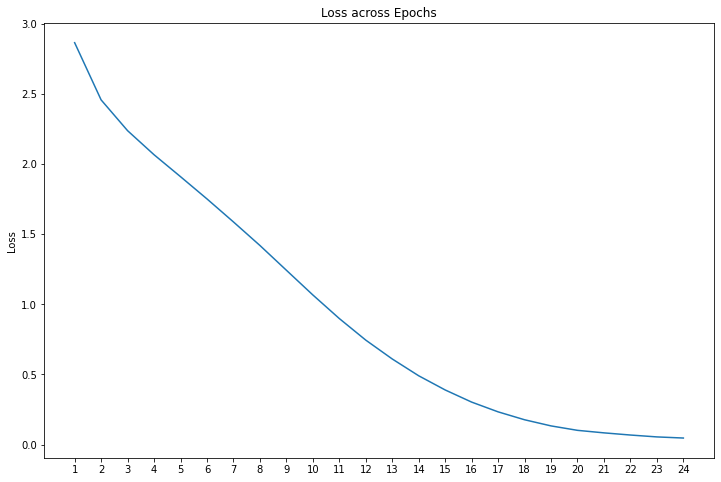

In [0]:
# plot loss across epochs
plt.figure(figsize=(12,8))
plt.plot([(i+1) for i in range(len(loss_history))], loss_history)
plt.xticks([(i+1) for i in range(len(loss_history))])
plt.ylabel('Loss')
plt.title('Loss across Epochs')
plt.show()

## Evaluation

In [0]:
def get_eval_tensor(sentence):
    processed_sentence = preprocess_sentence(sentence)
    try:
        inputs = [english_tokenizer.word_index[i] for i in processed_sentence.split(' ')]
        inputs = pad_sequences([inputs], maxlen=english_tensor.shape[1], padding='post')
        inputs = tf.convert_to_tensor(inputs)
        return inputs
    except:
        return [0 for _ in processed_sentence.split(' ')]
        # print('The Neural Network has not learned the word yet!')
    
def evaluate(sentence):
    result = ''
    # initialize encoder hidden layer
    hidden = [tf.zeros((1, DEC_HIDDEN_DIM))]
    enc_out, enc_hidden = encoder(get_eval_tensor(sentence), hidden, False)
    # False means not using dropout
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([chinese_tokenizer.word_index['<start>']], 0)

    attention_plot = np.zeros((chinese_tensor.shape[1], english_tensor.shape[1]))
    

    for t in range(english_tensor.shape[1]):
        predictions, dec_hidden, attention_weights = decoder(
            dec_input, dec_hidden, enc_out, False) 
        # False means not using dropout 

        predicted_id = tf.argmax(predictions[0]).numpy()
        attention_weights = tf.reshape(attention_weights, (-1,))
        attention_plot[t] = attention_weights.numpy()

        try:
            new_word = chinese_tokenizer.index_word[predicted_id] 
        except:
            pass
       
        result += new_word + ' '
        if chinese_tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, attention_plot

In [0]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = go.Figure(data = go.Heatmap(z=attention[:-1,:],
                                      x=sentence,
                                      y=[i for i in predicted_sentence[:-1][::-1]]))
    fig.update_xaxes(side="top")
    fig.update_layout(
        autosize=False,
        width=700,
        height=500,
        margin=dict(l=50, r=50, b=5, t=2, pad=4)
        )
    fig.show()

### Translate

In [0]:
def translate(sentence, plot=False, score=False):
    result, attention_plot = evaluate(sentence)
    if score == False:
        print(result.replace(' ', '').strip('<end>'))
    if score:
        return result.strip('<end> ')
    if plot:
        attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
        plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [0]:
translate('I am very hungry', plot = True)

我很餓。


In [0]:
translate('He is the only person I know', plot = True)

他是我认识的人。


In [0]:
translate('We move so fast that he cannot catch us', plot = True)

我们的天气得他能赶上他。


In [0]:
## Calculate BLEU Scores

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

test_dataset = tf.data.Dataset.from_tensor_slices((english_test, chinese_test)).shuffle(BUFFER_SIZE)

def convert(lang, tensor):
    words = []
    for t in tensor.numpy():
        if t!=0 and lang.index_word[t] not in ['<start>', '<end>']:
            words.append(lang.index_word[t])
    return words

scores = []
for eng, ref_trans in test_dataset:
    reference = [convert(chinese_tokenizer, ref_trans)]
    try:
        eng = ' '.join(convert(english_tokenizer, eng))
        eng = eng.replace('.', '')
        candidate = translate(eng, score=True)
        candidate = [i for i in candidate.split(' ')]
    except:
        pass

    score = sentence_bleu(reference, candidate)
    scores.append(score)

print(np.mean(scores))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning:


Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning:


Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning:


Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().



0.5230281683250283


Reference

https://www.tensorflow.org/tutorials/text/nmt_with_attention